In [2]:
# Libraries for general analysis
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Libraries for model building
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

# Libraries for plotting
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
# Loading the dataset of BTC prices
df=pd.read_csv('BTC-USD.csv')
df.head()

,Date,Close
0,1/1/20,7200.174316
1,1/2/20,6985.470215
2,1/3/20,7344.884277
3,1/4/20,7410.656738
4,1/5/20,7411.317383


In [4]:
# Specification of index to split the dataset into testing and training

split_index = 760

# Split the data into training and test sets
train = df.loc[df.index < split_index]
test = df.loc[df.index >= split_index]

train.tail()
test.head()

,Date,Close
760,1/30/22,37917.60156
761,1/31/22,38483.12500
762,2/1/22,38743.27344
763,2/2/22,36952.98438
764,2/3/22,37154.60156


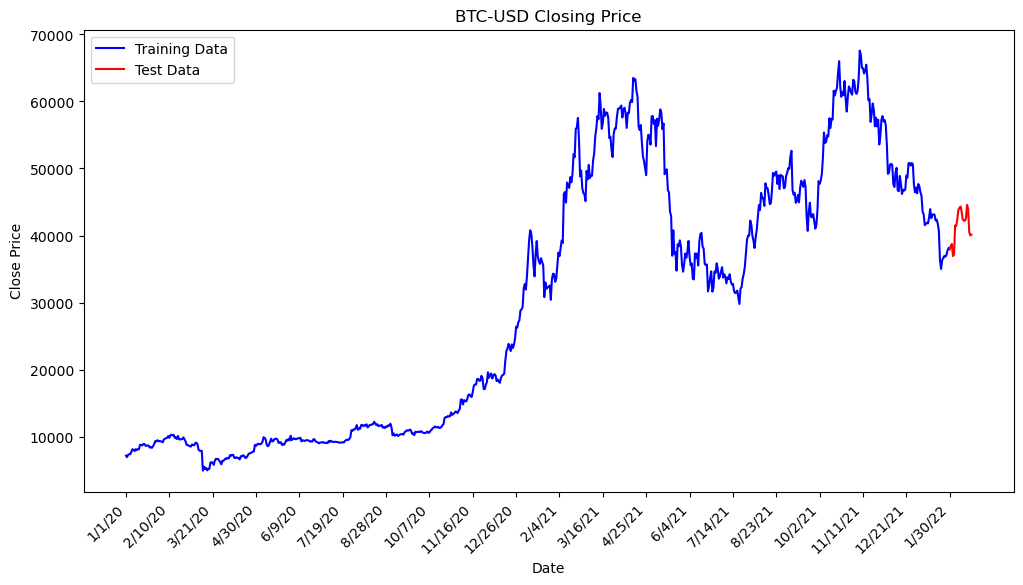

In [5]:
# Simple plot of full dataset showing training/testing split

plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Close'], color='blue', label='Training Data')
plt.plot(test['Date'], test['Close'], color='red', label='Test Data')
plt.xticks(df['Date'][::40], rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC-USD Closing Price')
plt.legend()
plt.show()

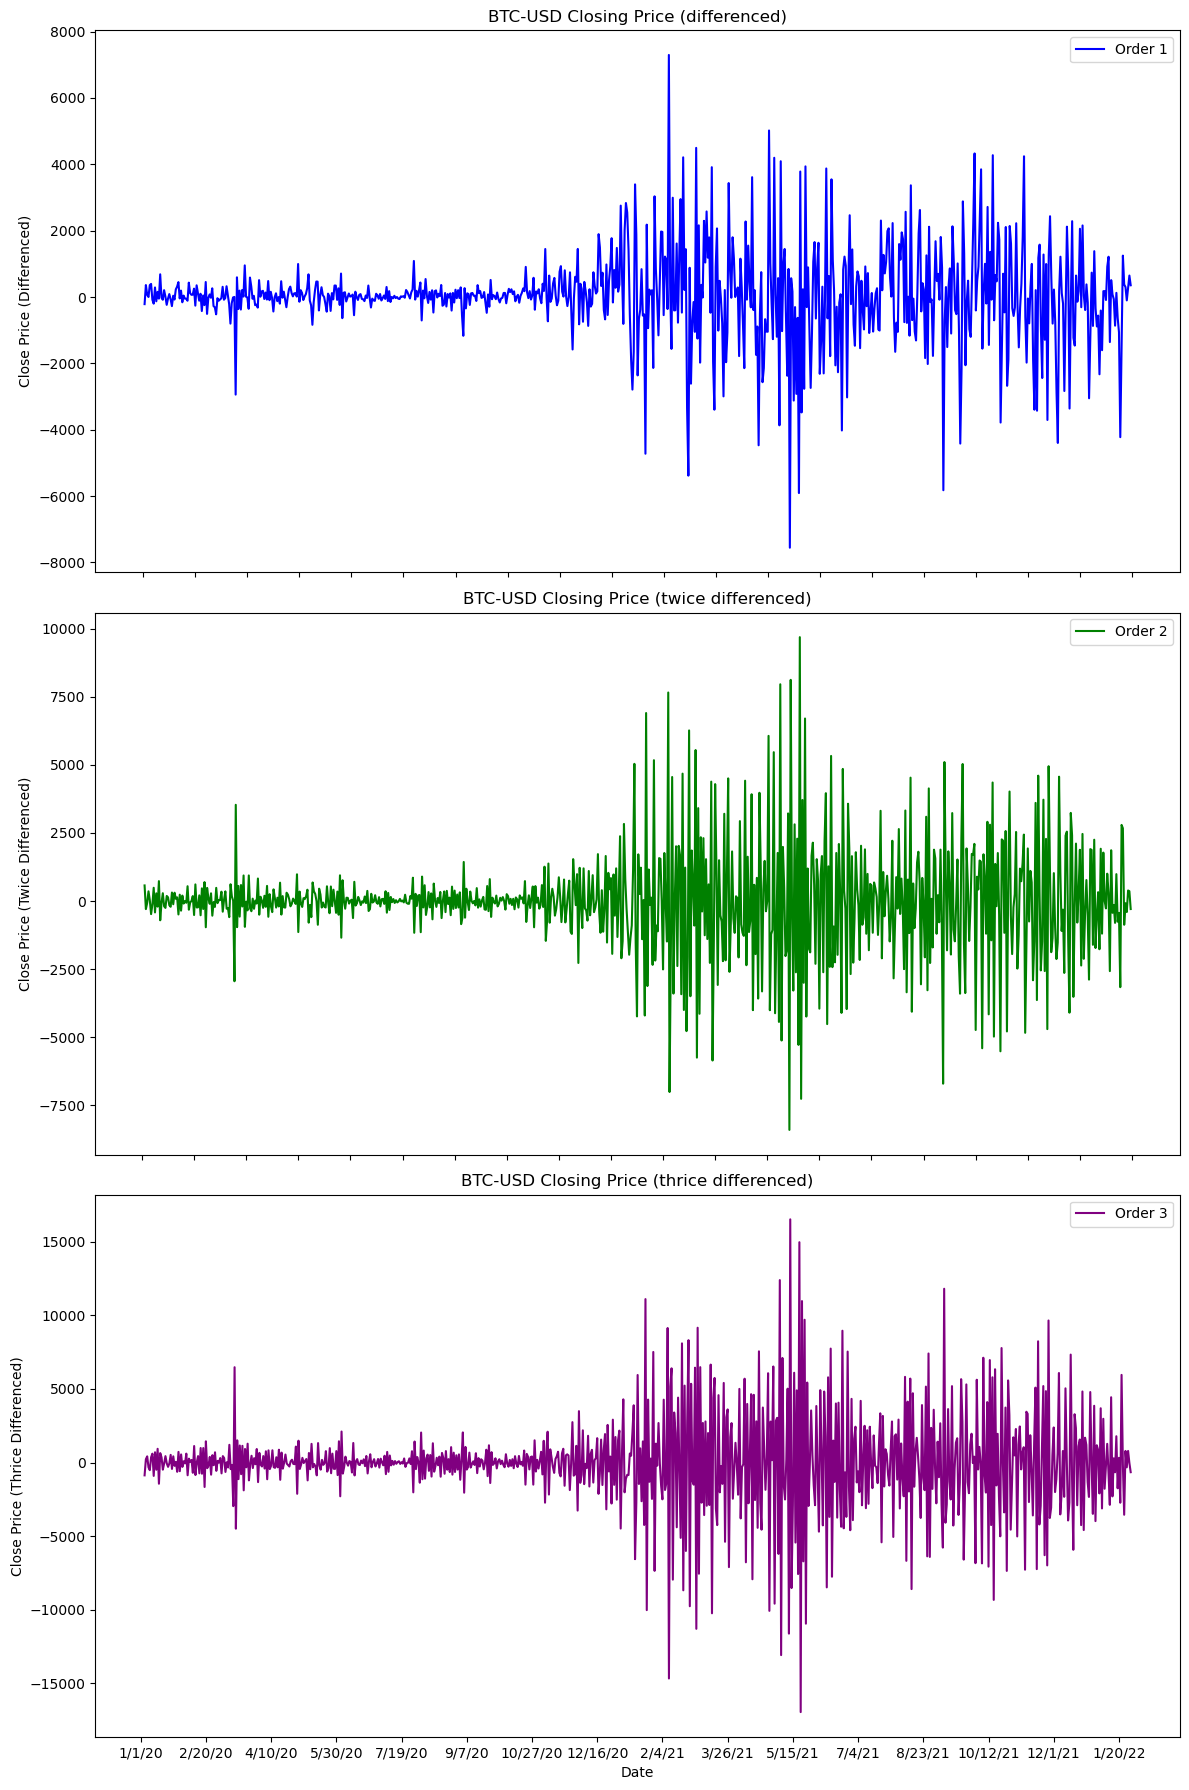

In [6]:
# Create a differenced training DataFrame (train_diff1)
train_diff1 = train.copy()
train_diff1['Close'] = train['Close'].diff(1)  # Differencing with order 1

# Differencing the 'Close' column of train_diff1 to create train_diff2
train_diff2 = train_diff1.copy()
train_diff2['Close'] = train_diff1['Close'].diff(1)  # Differencing with order 1

# Differencing the 'Close' column of train_diff2 to create train_diff3
train_diff3 = train_diff2.copy()
train_diff3['Close'] = train_diff2['Close'].diff(1)  # Differencing with order 1

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot the differenced training DataFrame (Order 1)
axes[0].plot(train_diff1['Date'], train_diff1['Close'], color='blue', label='Order 1')
axes[0].set_xticks(df['Date'][::40])
axes[0].set_xticklabels([])
axes[0].set_ylabel('Close Price (Differenced)')
axes[0].set_title('BTC-USD Closing Price (differenced)')
axes[0].legend()

# Plot the doubly differenced training DataFrame (Order 2)
axes[1].plot(train_diff2['Date'], train_diff2['Close'], color='green', label='Order 2')
axes[1].set_xticks(df['Date'][::40])
axes[1].set_xticklabels([])
axes[1].set_ylabel('Close Price (Twice Differenced)')
axes[1].set_title('BTC-USD Closing Price (twice differenced)')
axes[1].legend()

# Plot the triply differenced training DataFrame (Order 3)
axes[2].plot(train_diff3['Date'], train_diff3['Close'], color='purple', label='Order 3')
axes[2].set_xticks(df['Date'][::50])
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Close Price (Thrice Differenced)')
axes[2].set_title('BTC-USD Closing Price (thrice differenced)')
axes[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [8]:
# Copying testing/training datasets to perform Box-Cox transformations on
train_boxcox = train.copy()
test_boxcox = test.copy()

train_boxcox.tail()
test_boxcox.tail()

,Date,Close
776,2/15/22,44575.20313
777,2/16/22,43961.85938
778,2/17/22,40538.01172
779,2/18/22,40030.97656
780,2/19/22,40126.42969


In [9]:
# Assuming 'Close' is the column you want to transform in df_copy
column_to_transform = 'Close'

# Add a constant to ensure all values are positive
constant = abs(train_boxcox[column_to_transform].min()) + 1

# Perform Box-Cox transformation
train_boxcox[column_to_transform], lambda_value = boxcox(train_boxcox[column_to_transform] + constant)

# Apply the same transformation to the testing set using the lambda value obtained from the training set
test_boxcox[column_to_transform] = boxcox(test_boxcox[column_to_transform] + constant, lmbda=lambda_value)

In [10]:
train_boxcox.tail()
test_boxcox.head()

,Date,Close
760,1/30/22,27.646945
761,1/31/22,27.717023
762,2/1/22,27.749001
763,2/2/22,27.525596
764,2/3/22,27.551152


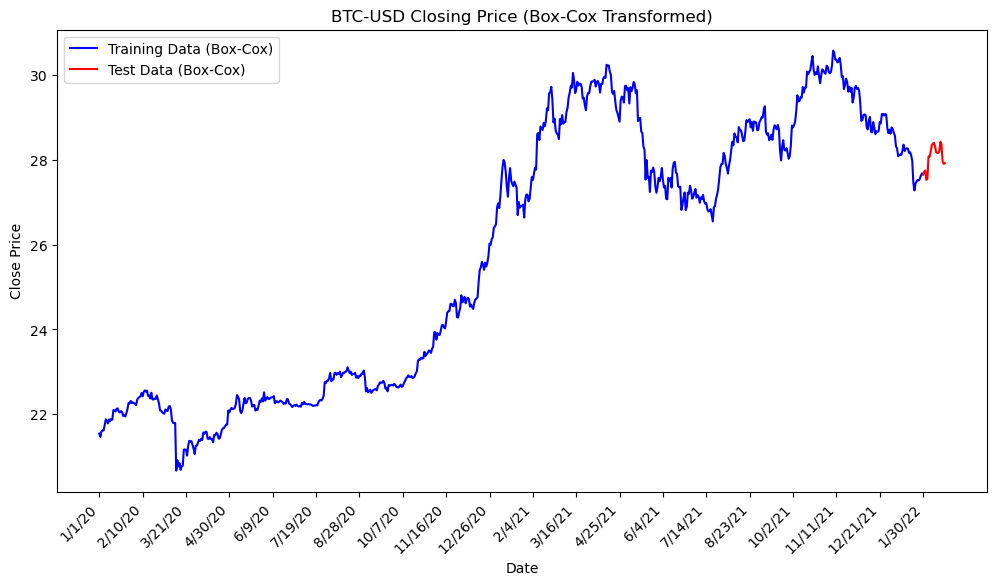

In [11]:
# Plot of closing price after Box-Cox transformation
plt.figure(figsize=(12, 6))
plt.plot(train_boxcox['Date'], train_boxcox['Close'], color='blue', label='Training Data (Box-Cox)')
plt.plot(test_boxcox['Date'], test_boxcox['Close'], color='red', label='Test Data (Box-Cox)')
plt.xticks(df['Date'][::40], rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC-USD Closing Price (Box-Cox Transformed)')
plt.legend()
plt.show()

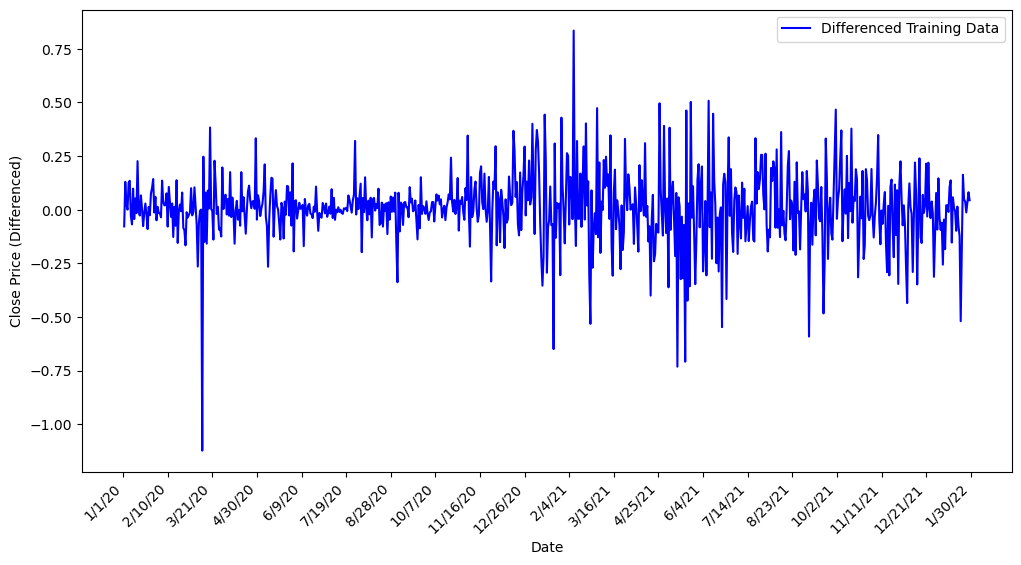

In [12]:
# Plot of differenced Box-Cox transformed data
plt.figure(figsize=(12, 6))
plt.plot(train_boxcox['Date'], train_boxcox['Close'].diff(), color='blue', label='Differenced Training Data')
plt.xticks(df['Date'][::40], rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Close Price (Differenced)')
plt.legend()
plt.show()

In [13]:
# Assuming 'Close' is the column you want to test in train_boxcox
column_to_test = 'Close'

# Perform the ADF test on the differenced series
result = adfuller(train_boxcox[column_to_test].diff().dropna())

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Check for stationarity based on the p-value
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -28.797252889072254
p-value: 0.0
The time series is likely stationary.


In [15]:
# Additional test to confirm stationarity
from pmdarima.arima.utils import ndiffs
ndiffs(train_boxcox['Close'], test="adf")

1

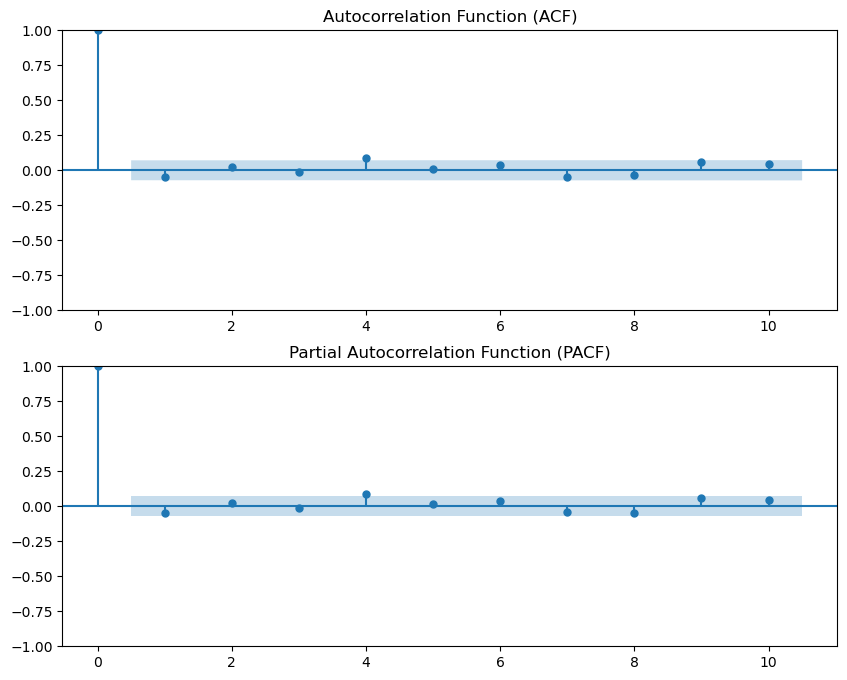

In [17]:
import statsmodels.api as sm

# Looking at ACF and PACF plots to inform our model choice for ARIMA

# Assuming 'Close' is the column you want to analyze in train_boxcox.diff()
column_to_analyze = 'Close'

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
sm.graphics.tsa.plot_acf(train_boxcox[column_to_analyze].diff().dropna(), lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
sm.graphics.tsa.plot_pacf(train_boxcox[column_to_analyze].diff().dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

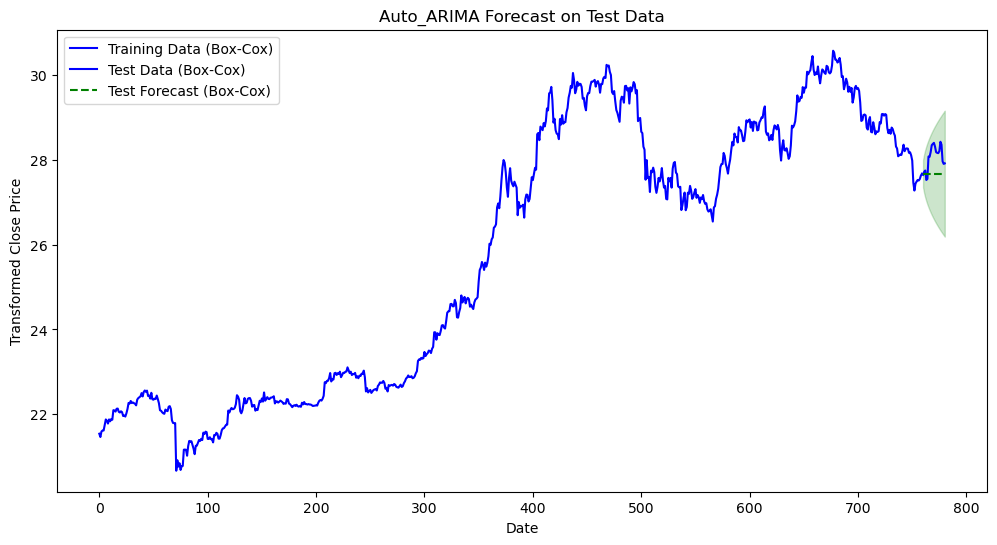

In [18]:
# Assuming 'Close' is the column you want to forecast in train_boxcox and test_boxcox
column_to_forecast = 'Close'

# Perform auto_arima fit on the training data
model = auto_arima(train_boxcox[column_to_forecast], suppress_warnings=True, seasonal=False)

# Get the forecast for the test set
test_forecast, test_conf_int = model.predict(n_periods=len(test_boxcox), return_conf_int=True)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the training data in blue
plt.plot(train_boxcox.index, train_boxcox[column_to_forecast], label='Training Data (Box-Cox)', color='blue')

# Plot the test data in blue
plt.plot(test_boxcox.index, test_boxcox[column_to_forecast], label='Test Data (Box-Cox)', color='blue')

# Plot the forecast for the test set in green
plt.plot(test_boxcox.index, test_forecast, label='Test Forecast (Box-Cox)', color='green', linestyle='dashed')

# Fill the confidence interval for the test set forecast
plt.fill_between(test_boxcox.index, test_conf_int[:, 0], test_conf_int[:, 1], color='green', alpha=0.2)

plt.title('Auto_ARIMA Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Transformed Close Price')
plt.legend()
plt.show()

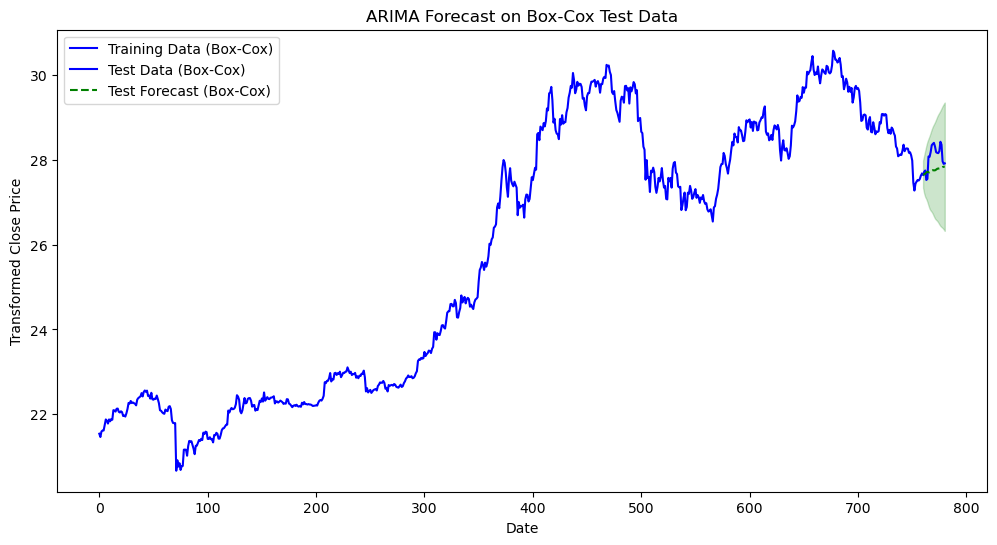

In [19]:
from pmdarima import ARIMA

# Assuming 'Close' is the column you want to forecast in train_boxcox and test_boxcox
column_to_forecast = 'Close'

# Specify the ARIMA parameters
p = 4  # Autoregressive order
d = 1  # Differencing order
q = 4 # Moving average order

# Initialize and fit the ARIMA model
model = ARIMA(order=(p, d, q), suppress_warnings=True)
model.fit(train_boxcox[column_to_forecast])

# Get the forecast for the test set
test_forecast, test_conf_int = model.predict(n_periods=len(test_boxcox), return_conf_int=True)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the training data in blue
plt.plot(train_boxcox.index, train_boxcox[column_to_forecast], label='Training Data (Box-Cox)', color='blue')

# Plot the test data in blue
plt.plot(test_boxcox.index, test_boxcox[column_to_forecast], label='Test Data (Box-Cox)', color='blue')

# Plot the forecast for the test set in green
plt.plot(test_boxcox.index, test_forecast, label='Test Forecast (Box-Cox)', color='green', linestyle='dashed')

# Fill the confidence interval for the test set forecast
plt.fill_between(test_boxcox.index, test_conf_int[:, 0], test_conf_int[:, 1], color='green', alpha=0.2)

plt.title('ARIMA Forecast on Box-Cox Test Data')
plt.xlabel('Date')
plt.ylabel('Transformed Close Price')
plt.legend()
plt.show()

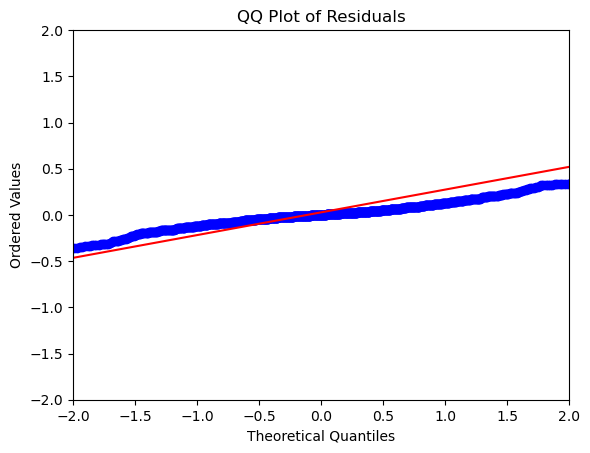

In [20]:
from scipy.stats import probplot 
residuals = model.resid()

# QQ plot of residuals
probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

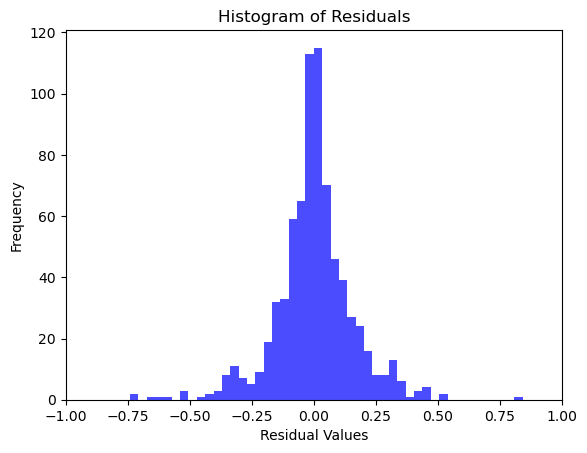

In [22]:
# Check for normal distribution of residuals
plt.hist(residuals, bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Values')
plt.xlim(-1, 1)
plt.ylabel('Frequency')
plt.show()

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test for autocorrelation in residuals
lb_test_result = acorr_ljungbox(residuals, lags=20)

# Print the full result
print(f'Ljung-Box Test - Full Result: {lb_test_result}')

Ljung-Box Test - Full Result:      lb_stat  lb_pvalue
1   0.012404   0.911321
2   0.031187   0.984528
3   0.033772   0.998366
4   0.033829   0.999859
5   0.047814   0.999974
6   0.092404   0.999984
7   0.095663   0.999998
8   0.115421   1.000000
9   0.134453   1.000000
10  0.135853   1.000000
11  0.139753   1.000000
12  0.142276   1.000000
13  0.259588   1.000000
14  0.259671   1.000000
15  0.270342   1.000000
16  0.275945   1.000000
17  0.280741   1.000000
18  0.313533   1.000000
19  0.321812   1.000000
20  0.331155   1.000000


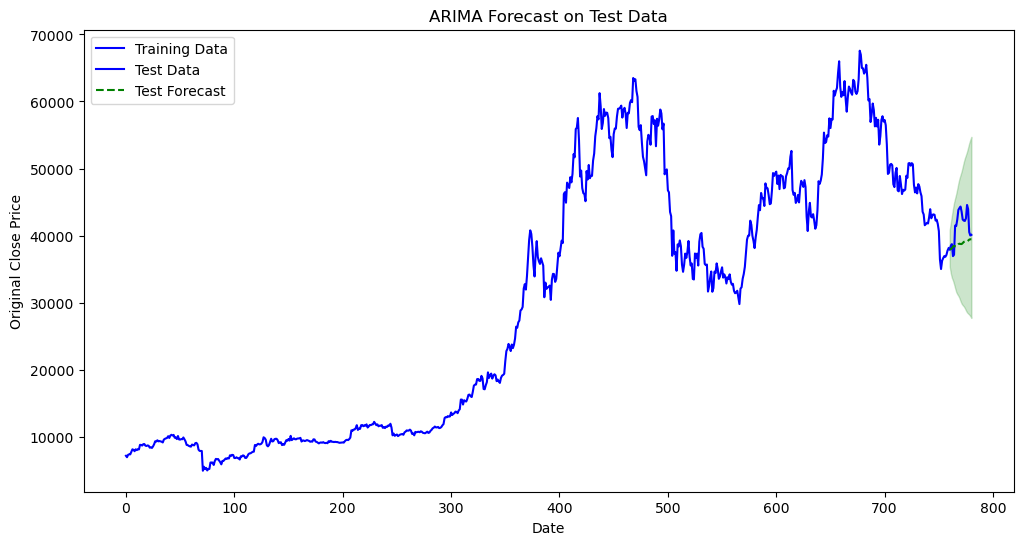

In [25]:
from pmdarima import ARIMA
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Assuming 'Close' is the column you want to forecast in train and test
column_to_forecast = 'Close'

# Perform Box-Cox transformation on the training data
train_boxcox, lambda_value = boxcox(train[column_to_forecast] + 1)

# Specify the ARIMA parameters
p = 4  # Autoregressive order
d = 1  # Differencing order
q = 4  # Moving average order

# Initialize and fit the ARIMA model
model = ARIMA(order=(p, d, q), suppress_warnings=True)
model.fit(train_boxcox)

# Get the forecast for the test set
test_forecast_boxcox, test_conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Inverse Box-Cox transformation for the forecasted values
test_forecast_original_scale = inv_boxcox(test_forecast_boxcox, lambda_value) - 1

# Plot the results using the original scale
plt.figure(figsize=(12, 6))

# Plot the training data in blue
plt.plot(train.index, train[column_to_forecast], label='Training Data', color='blue')

# Plot the test data in blue
plt.plot(test.index, test[column_to_forecast], label='Test Data', color='blue')

# Plot the untransformed forecast for the test set in green
plt.plot(test.index, test_forecast_original_scale, label='Test Forecast', color='green', linestyle='dashed')

# Fill the confidence interval for the test set forecast
lower_bound = inv_boxcox(test_conf_int[:, 0], lambda_value) - 1
upper_bound = inv_boxcox(test_conf_int[:, 1], lambda_value) - 1
plt.fill_between(test.index, lower_bound, upper_bound, color='green', alpha=0.2)

plt.title('ARIMA Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Original Close Price')
plt.legend()
plt.show()